# 波段合并

In [9]:
from osgeo import gdal
import numpy as np

# 各波段文件路径
band_files = [
    "data/Landsat8/B1.tif",
    "data/Landsat8/B2.tif",
    "data/Landsat8/B3.tif",
    "data/Landsat8/B4.tif",
    "data/Landsat8/B5.tif",
    "data/Landsat8/B6.tif",
    "data/Landsat8/B7.tif",
    "data/Landsat8/B8.tif"
]

# 打开第一个波段作为参考
ref_band = gdal.Open(band_files[0])
if ref_band is None:
    raise FileNotFoundError("无法打开第一个波段文件！")

# 获取影像基本信息
width = ref_band.RasterXSize
height = ref_band.RasterYSize
geo_transform = ref_band.GetGeoTransform()   # 地理变换信息
projection = ref_band.GetProjection()        # 投影信息

# 读取各波段数据
band_data = [gdal.Open(b).ReadAsArray() for b in band_files]

# 创建输出影像
driver = gdal.GetDriverByName('GTiff')
output_file = 'combine_landsat8.tif'
dataset = driver.Create(output_file, width, height, 8, gdal.GDT_Float32)

# 设置地理参考信息
dataset.SetGeoTransform(geo_transform)
dataset.SetProjection(projection)

# 写入波段数据
for i, data in enumerate(band_data, start=1):
    band = dataset.GetRasterBand(i)
    band.WriteArray(data)
    band.SetNoDataValue(-9999)

# 关闭数据集
dataset = None
print("影像合并完成并保留地理参考，保存为 'combine_landsat8.tif'！")


影像合并完成并保留地理参考，保存为 'combine_landsat8.tif'！


In [10]:
#使用gdal元命令gdal info查看文件元数据信息
!gdalinfo combine_landsat8.tif

Driver: GTiff/GeoTIFF
Files: combine_landsat8.tif
Size is 2331, 2370
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 50N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 50N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",117,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
      

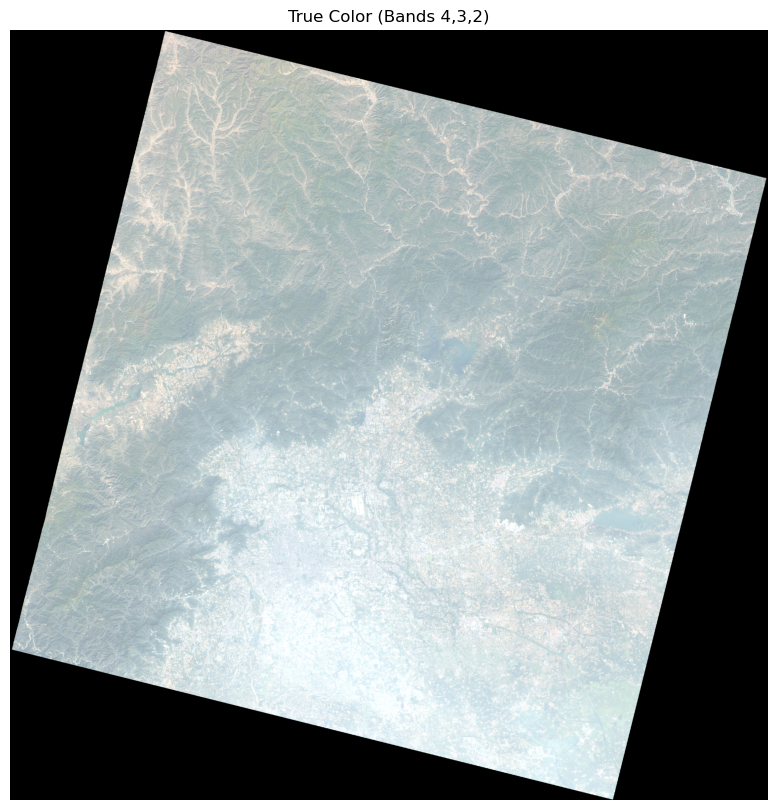

In [11]:
# 结果可视化
import matplotlib.pyplot as plt

def plot_true_color(dataset, bands=(4, 3, 2), stretch_percentiles=(2, 98), figsize=(10, 10)):
    if dataset is None:
        raise ValueError("需要提供包含波段的GDAL数据集")
    if dataset.RasterCount < max(bands):
        raise ValueError(f"数据集中不包含请求的波段: {bands}")
    pmin, pmax = stretch_percentiles

    def stretch(arr):
        lo, hi = np.nanpercentile(arr, (pmin, pmax))
        if hi == lo:
            return np.clip((arr - lo), 0, 1)
        return np.clip((arr - lo) / (hi - lo), 0, 1)

    band_arrays = [dataset.GetRasterBand(idx).ReadAsArray().astype(np.float32) for idx in bands]
    stretched = [stretch(arr) for arr in band_arrays]
    rgb = np.dstack(stretched)

    plt.figure(figsize=figsize)
    plt.imshow(rgb)
    plt.axis('off')
    plt.title(f'True Color (Bands {bands[0]},{bands[1]},{bands[2]})')
    plt.show()

dataset_tc = gdal.Open('combine_landsat8.tif')
plot_true_color(dataset_tc)
dataset_tc = None

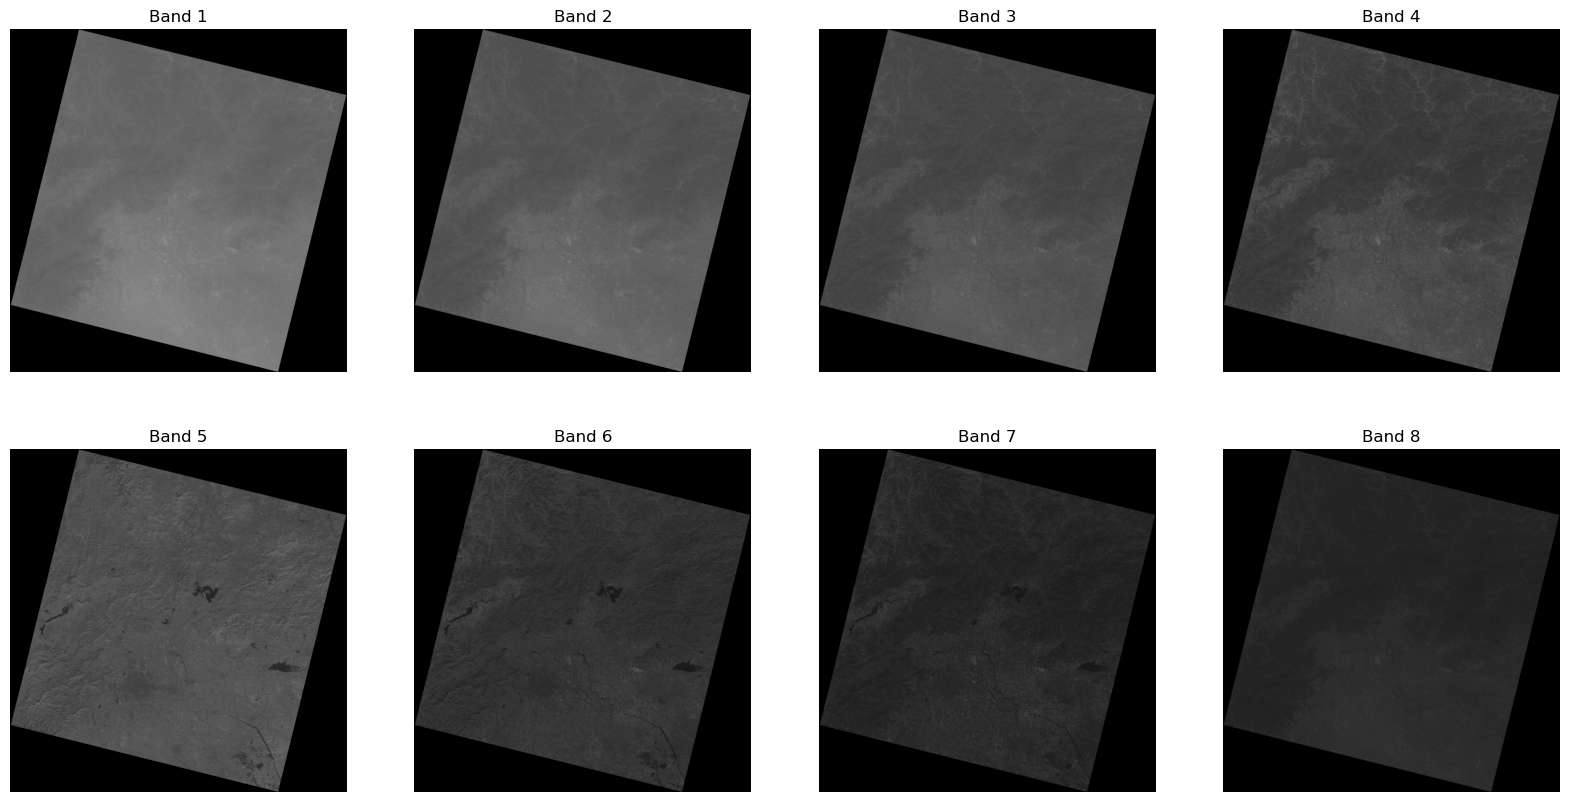

In [12]:
#绘制所有八个波段到一个子图
dataset = gdal.Open("combine_landsat8.tif")
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    band = dataset.GetRasterBand(i + 1).ReadAsArray()
    ax = axs[i // 4, i % 4]
    ax.imshow(band, cmap='gray')
    ax.set_title(f'Band {i + 1}')
    ax.axis('off')
plt.show()

# 遥感影像切割


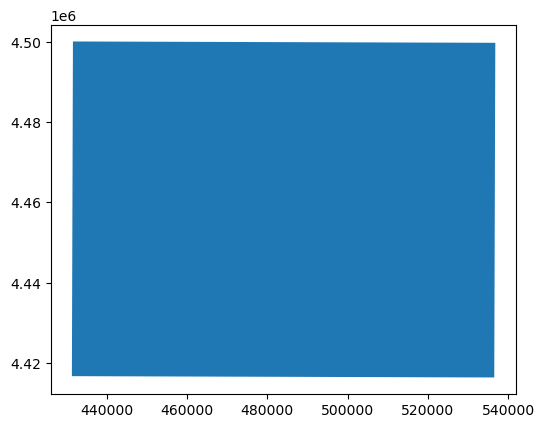

In [13]:
#可视化矢量数据
import matplotlib.pyplot as plt
from geopandas import gpd

shapefile = "data/aoi.shp"
gdf = gpd.read_file(shapefile)

# 绘制矢量数据
gdf.plot()
plt.show()

In [17]:
from osgeo import gdal, ogr

input_image = 'combine_landsat8.tif'
shapefile = 'data/aoi.shp'
output_image = 'aoi_landsat8.tif'

dataset = gdal.Open(input_image)
if dataset is None:
    raise FileNotFoundError("影像文件打开失败！")

vector = ogr.Open(shapefile)
if vector is None:
    raise FileNotFoundError("矢量文件打开失败！")

layer = vector.GetLayer()
shp_srs = layer.GetSpatialRef()
if shp_srs:
    print("矢量坐标系：", shp_srs.ExportToProj4())

out_ds = gdal.Warp(
    output_image,
    dataset,
    format='GTiff',
    cutlineDSName=shapefile,
    cropToCutline=True,
    dstNodata=-9999,
    cutlineSRS=None  # 自动匹配坐标
)

if out_ds is None:
    raise RuntimeError("gdal.Warp 裁剪失败！")
else:
    out_ds = None
    print(f"影像裁剪完成，保存为 '{output_image}'")


矢量坐标系： +proj=utm +zone=50 +datum=WGS84 +units=m +no_defs
影像裁剪完成，保存为 'aoi_landsat8.tif'


In [18]:
!gdalinfo aoi_landsat8.tif

Driver: GTiff/GeoTIFF
Files: aoi_landsat8.tif
Size is 1053, 836
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 50N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 50N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",117,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PAR

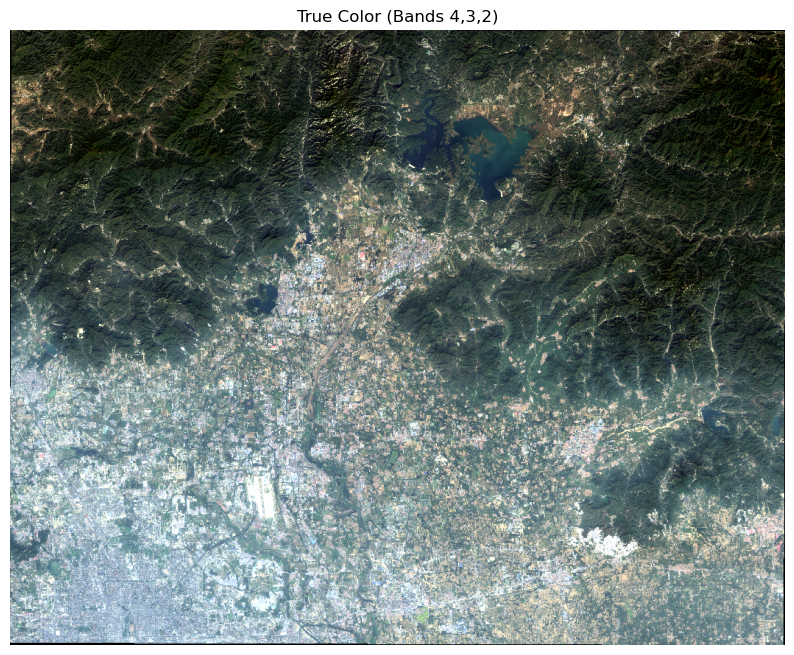

In [19]:
# 可视化4,3,2波段裁剪结果，真彩色
plot_true_color(gdal.Open(output_image), bands=(4, 3, 2))

# 计算NDVI指数

In [20]:
from osgeo import gdal
import numpy as np

ndvi_output = "ndvi_landsat8.tif"
src_ds = gdal.Open("aoi_landsat8.tif")
if src_ds is None:
    raise FileNotFoundError("裁剪影像文件打开失败！")

red_band = src_ds.GetRasterBand(4).ReadAsArray().astype(np.float32)
nir_band = src_ds.GetRasterBand(5).ReadAsArray().astype(np.float32)

np.seterr(divide='ignore', invalid='ignore')
ndvi = (nir_band - red_band) / (nir_band + red_band)
ndvi = np.where(np.isfinite(ndvi), ndvi, -9999)

driver = gdal.GetDriverByName("GTiff")
ndvi_ds = driver.Create(
    ndvi_output,
    src_ds.RasterXSize,
    src_ds.RasterYSize,
    1,
    gdal.GDT_Float32
)
ndvi_ds.SetGeoTransform(src_ds.GetGeoTransform())
ndvi_ds.SetProjection(src_ds.GetProjection())
ndvi_band = ndvi_ds.GetRasterBand(1)
ndvi_band.WriteArray(ndvi)
ndvi_band.SetNoDataValue(-9999)
ndvi_band.FlushCache()

src_ds = None
ndvi_ds = None
print(f"NDVI 计算完成，保存为 '{ndvi_output}'")

NDVI 计算完成，保存为 'ndvi_landsat8.tif'


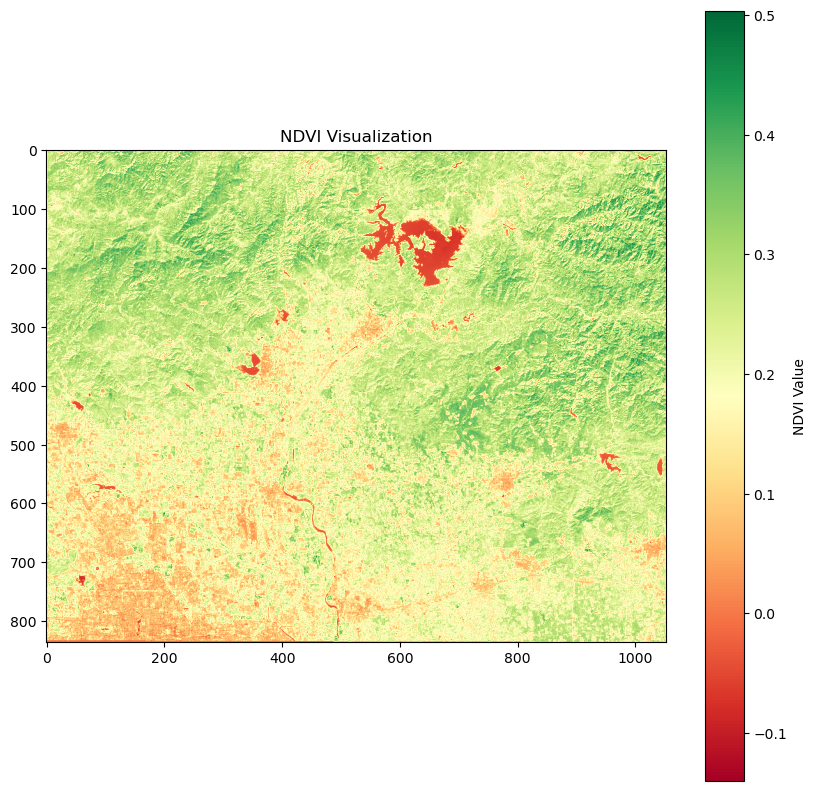

In [21]:
# 可视化ndvi
ndvi_ds = gdal.Open(ndvi_output)
ndvi_array = ndvi_ds.GetRasterBand(1).ReadAsArray()
plt.figure(figsize=(10, 10))
ndvi_plot = plt.imshow(ndvi_array, cmap='RdYlGn')
plt.colorbar(ndvi_plot, label='NDVI Value')
plt.title('NDVI Visualization')
plt.show()